# California Housing Prices

[https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv]

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("housing.csv")
columns = df.columns
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.dropna(inplace=True)
df.isna().sum()


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

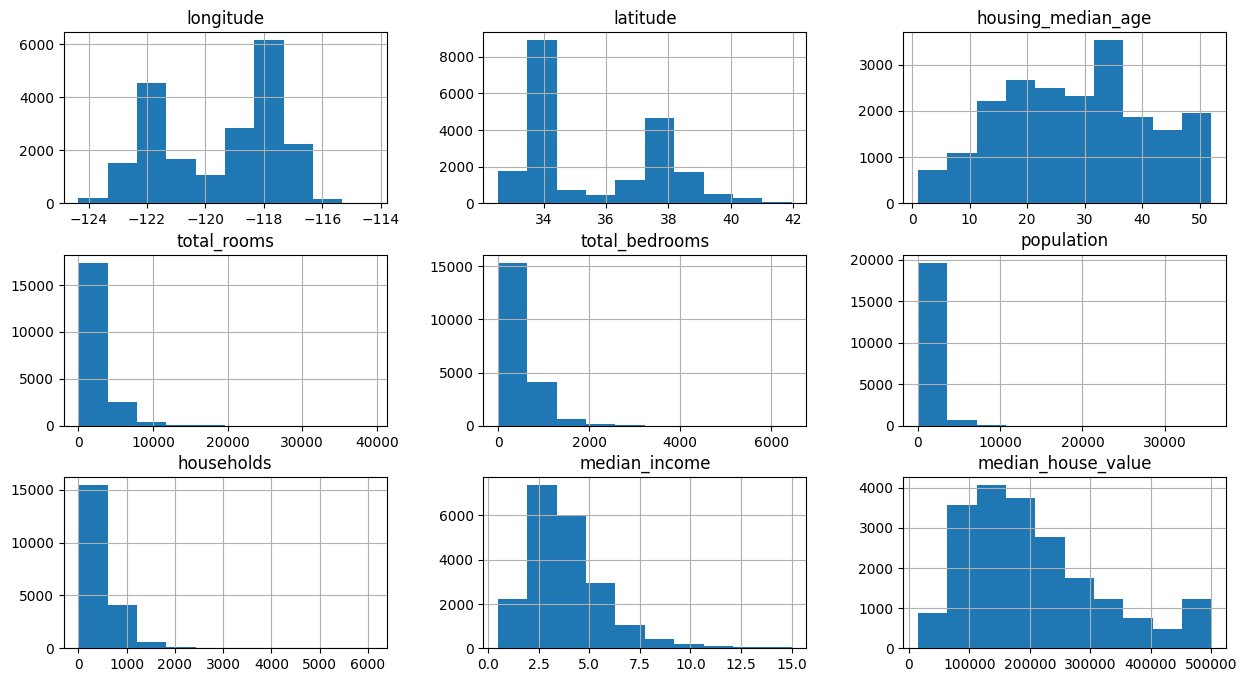

In [4]:
df.hist(figsize=(15,8))
plt.show()

<Axes: >

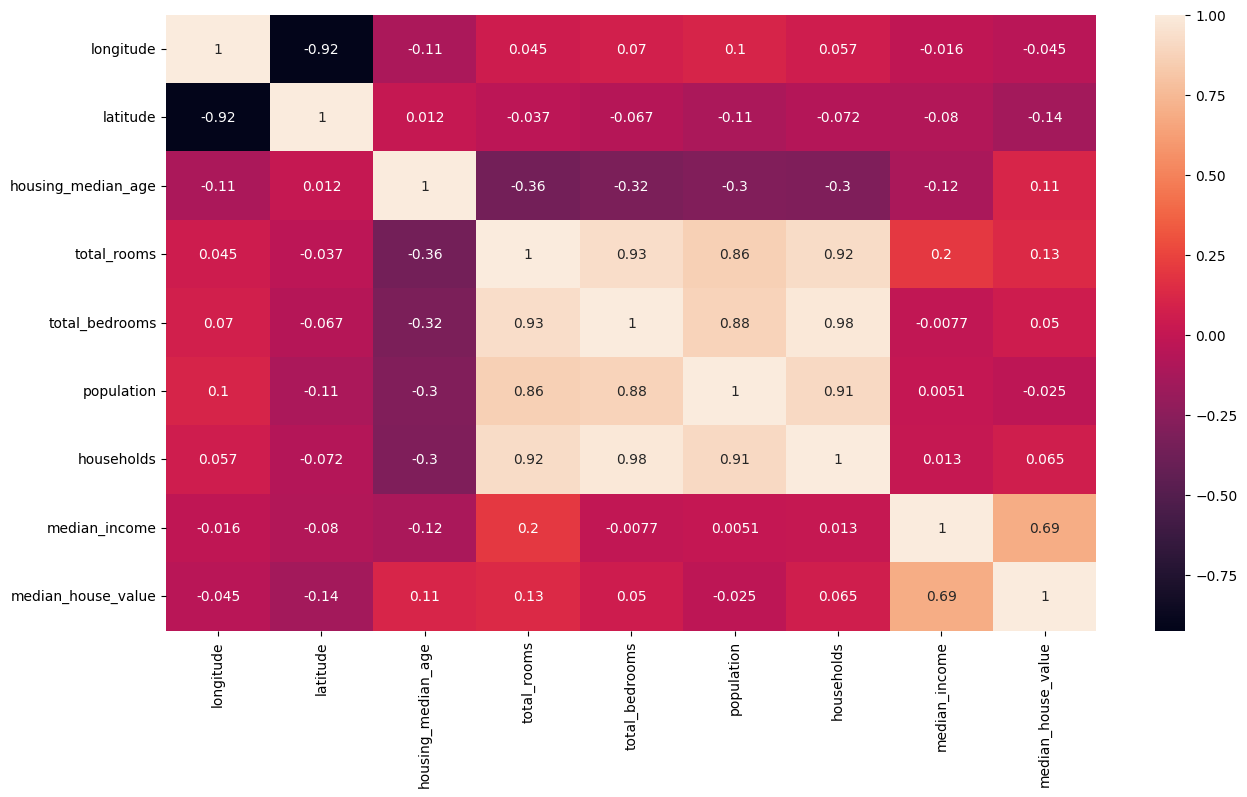

In [5]:
numeric_columns = df.select_dtypes(include=['number'])

plt.figure(figsize=(15,8))
sns.heatmap(numeric_columns.corr(), annot=True)

In [6]:
print(df.columns)
zero_values_check_all = df.eq(0.0).any()

print("Features with zero values:")
print(zero_values_check_all)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
Features with zero values:
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool


In [7]:
def make_feature_sym(train_data):
    train_data = train_data.copy()
    train_data["total_rooms"] = np.log(train_data["total_rooms"]+1) 
    train_data["total_bedrooms"] = np.log(train_data["total_bedrooms"]+1)
    train_data["population"] = np.log(train_data["population"]+1)
    train_data["households"] = np.log(train_data["households"]+1)
    return train_data

df = make_feature_sym(df)

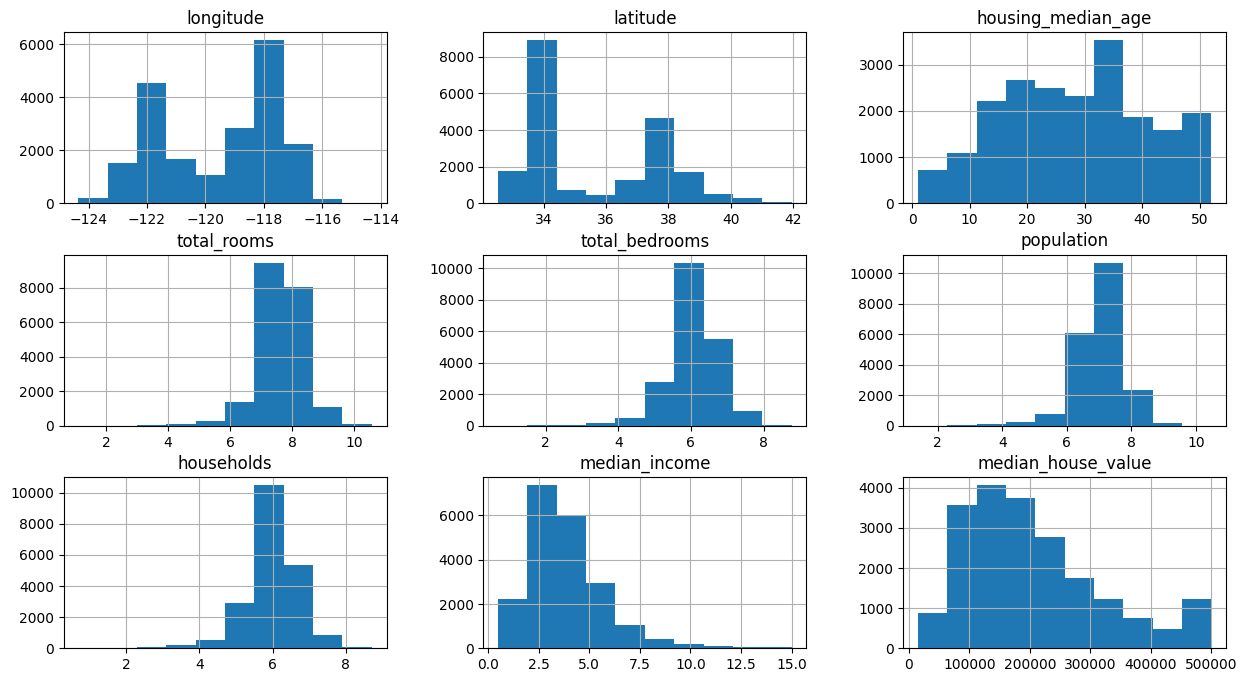

In [8]:
df.hist(figsize=(15,8))
plt.show()

In [9]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [10]:
ocean_proximity_df = pd.get_dummies(df["ocean_proximity"]).astype("Int64")
df.drop("ocean_proximity",
                axis=1,
                inplace=True)

df = pd.merge(df, ocean_proximity_df, right_index=True, left_index=True)

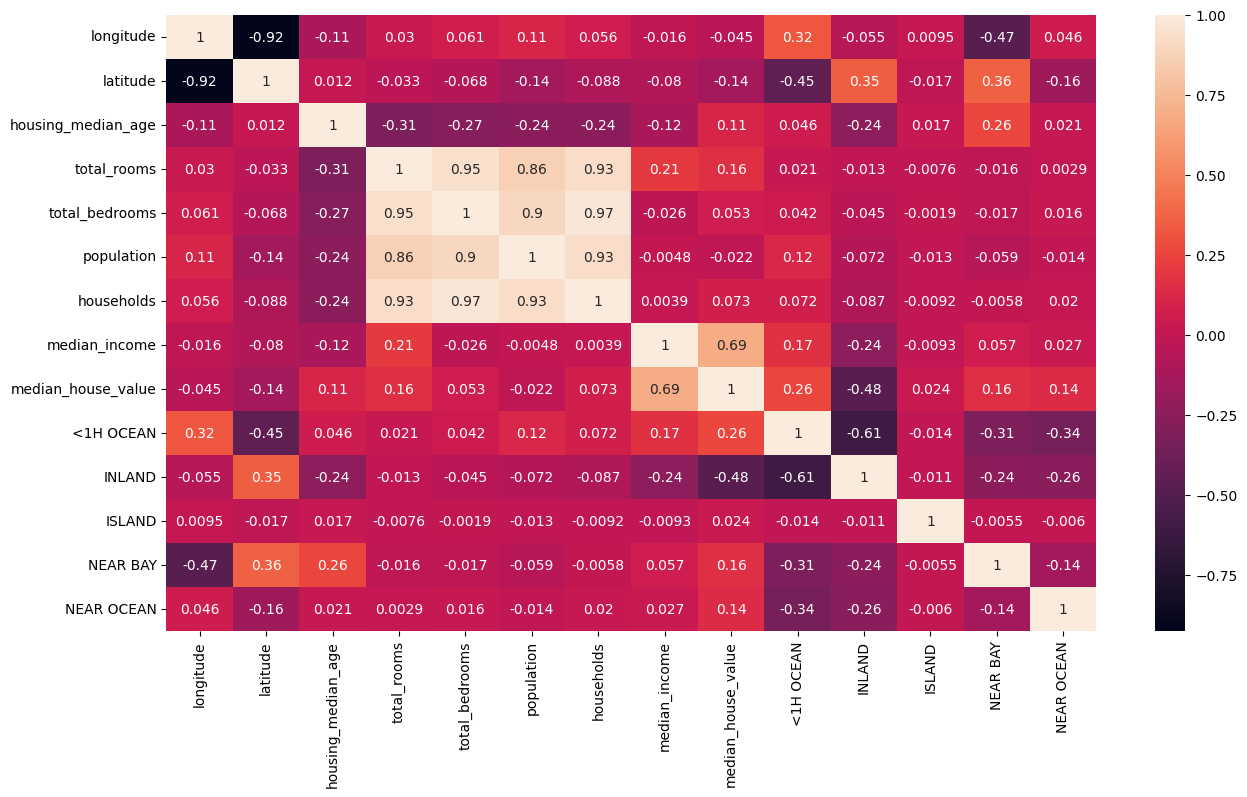

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

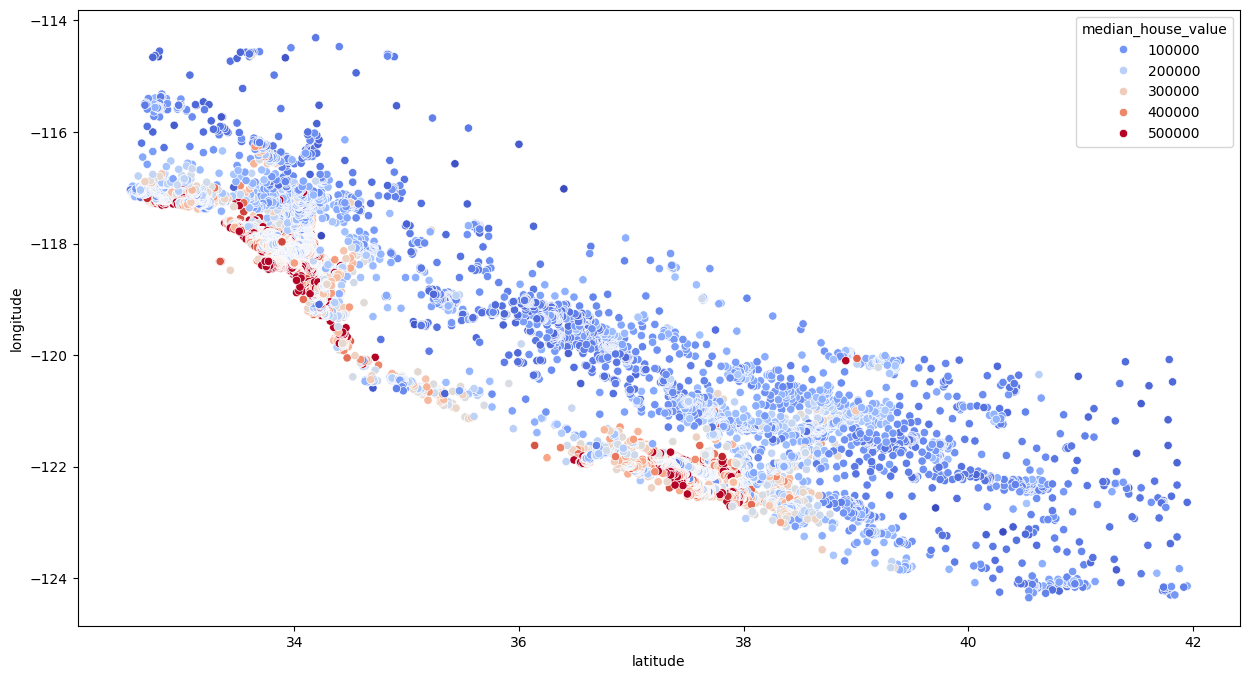

In [12]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="latitude", y="longitude", data=df, hue="median_house_value", palette="coolwarm")
plt.show()

In [13]:
def create_features(train_data):
    train_data = train_data.copy()
    train_data["bedroom_racio"] = train_data["total_bedrooms"] / train_data["total_rooms"]
    train_data["household_room"] = train_data["total_rooms"] / train_data["households"]
    return train_data

df = create_features(df)

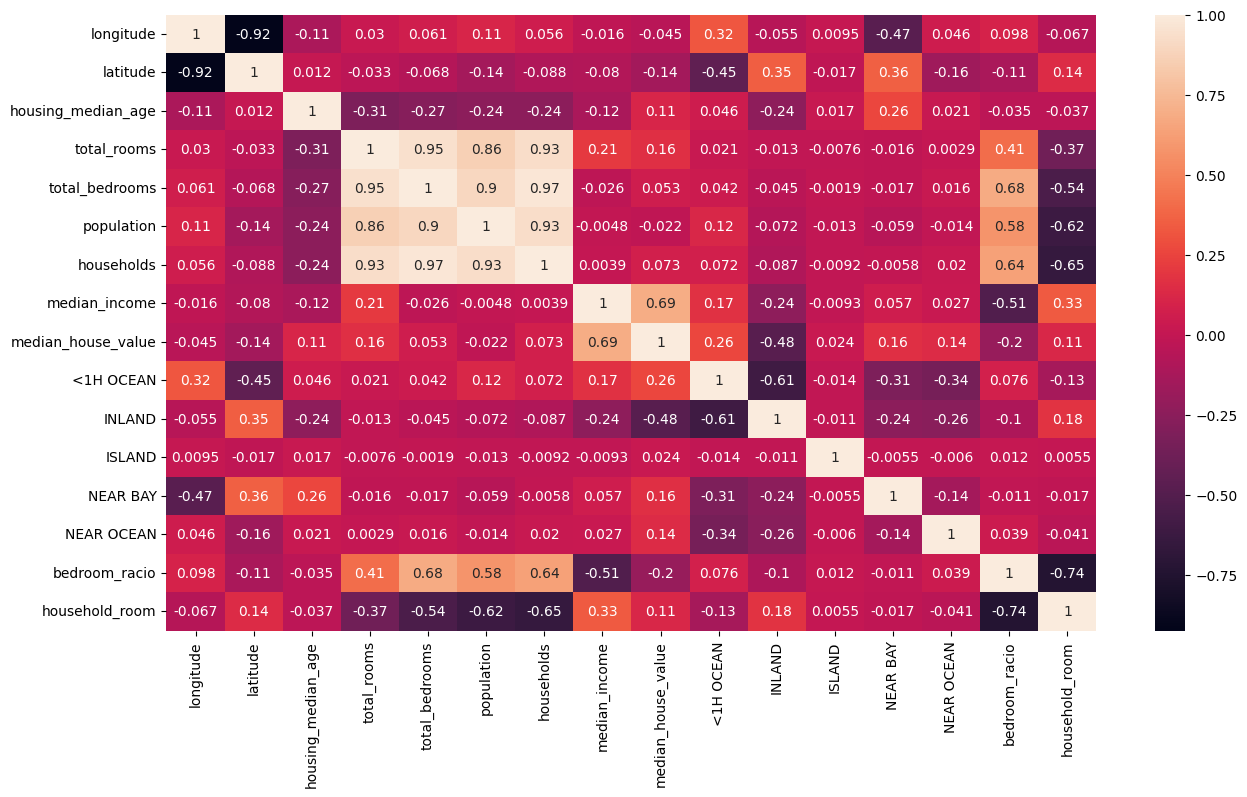

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [15]:
features = df.columns[df.columns != "median_house_value"]
target = df.columns[-8]
print(df.columns)
x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=42)

ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'bedroom_racio', 'household_room'],
      dtype='object')


In [16]:
# for column in x_train.columns:
#     is_inf = np.isinf(x_train[column])
#     # rows_with_inf = np.any(is_inf, axis=1)
#     cols_with_inf = np.any(is_inf, axis=0)
#     print(cols_with_inf, column)

In [17]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [18]:
y_pred = reg.predict(x_test)

score = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {score}")

Mean Absolute Error: 48035.13188397754


In [19]:
reg.score(x_test, y_test)

0.6753647670323645

In [20]:
fores_reg = RandomForestRegressor()

fores_reg.fit(x_train, y_train)

RandomForestRegressor()

In [21]:
fores_reg.score(x_test, y_test)

0.7627961915115975

In [29]:
fores_reg = RandomForestRegressor()
param_grid = {
    "n_estimators": [50, 100, 200, 400],
    "max_features":  [6, 8, 10, 12],
    # "min_samples_split": [2, 4, 6, 8]
}

grid_search = GridSearchCV(fores_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error", 
                           return_train_score=True)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [6, 8, 10, 12],
                         'n_estimators': [50, 100, 200, 400]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
best_forest = grid_search.best_estimator_

best_forest

RandomForestRegressor(max_features=12, n_estimators=400)

In [31]:
best_forest.score(x_test, y_test)

0.7705463741564831

In [35]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
xgb.score(x_test, y_test)

0.6892829670360449